#### Import

In [6]:
import sys
sys.path.insert(0,'..')
import urx
import time
import math3d as m3d
ur = urx.Robot("192.168.1.10", use_rt=True)
pose = ur.get_pose()
print(pose)
from ddh import DDGripper
from scooping_primitives import HighSpeedScooping
from jupyterthemes import jtplot
white = 1
if white:
    jtplot.style(theme='default', figsize=(25, 8))
else:
    jtplot.style(figsize=(25, 8))

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 68
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1092
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


<Transform:
<Orientation: 
array([[ 5.59534608e-05,  8.66036164e-01, -4.99981359e-01],
       [ 9.99999997e-01, -7.78033916e-05, -2.28550325e-05],
       [-5.86935302e-05, -4.99981356e-01, -8.66036166e-01]])>
<Vector: (-0.52219, 0.45002, 0.22359)>
>


In [3]:
gripper = DDGripper("ddh_scooping")
scoop = HighSpeedScooping(ur, gripper, "hss_green_domino_fast")

reading gripper config...
connecting to odrive...
found left finger
found right fingers
reading scooping config...


In [7]:
scoop.initialize_pose((-0.505,0.45,180))

Setting left tip: (152.15, 31.27609076372691)
Setting right tip: (128.5, 2.239092362730858)
Setting pose: 
[-0.5222      0.45        0.25       -1.92687451 -1.92687451  0.51630447]


Start logging
Collision detected!
Setting left tip: (155, 45)
Setting right tip: (155, -45)
Reached zero speed!
==========Scooping completed!==========
Speed at collision: -0.39784 m/s
Distance to decelerate: 0.06561 m
Deceleration for lifting: 3.95696 m/s^2
Slept time for lifting: 0.55 s
Lifted distance: 0.23406 m
Stop logging
Commanded time: 1211 ms


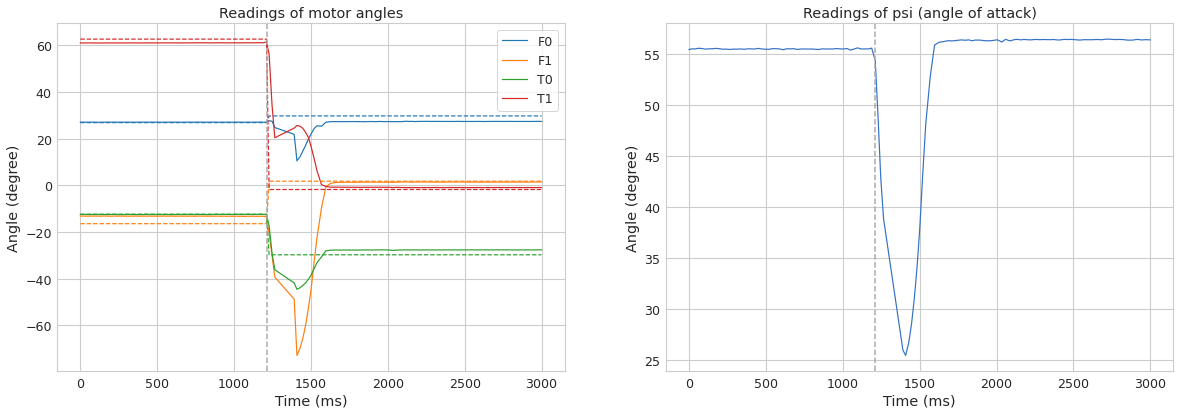

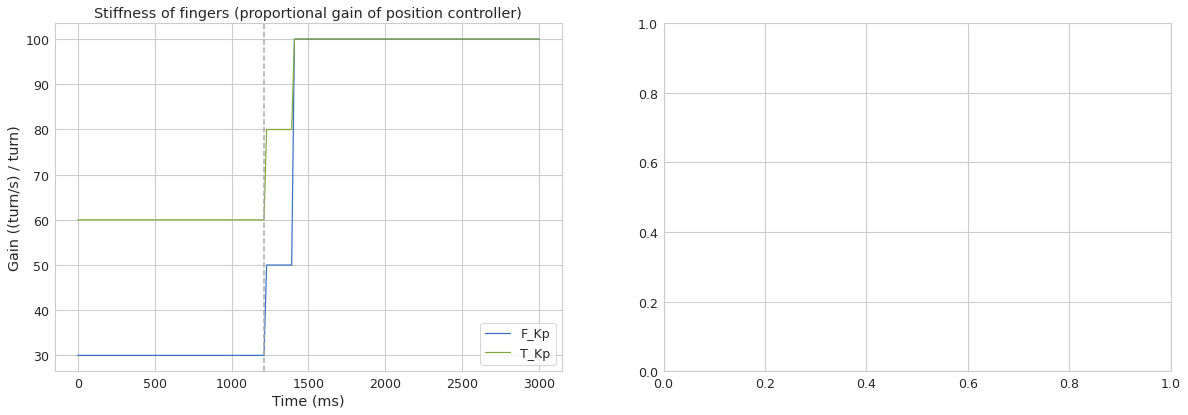

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/john/anaconda3/envs/scoop/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "../urx/ursecmon.py", line 293, in run
    data = self._get_data()
  File "../urx/ursecmon.py", line 340, in _get_data
    tmp = self._s_secondary.recv(1024)
socket.timeout: timed out

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/john/anaconda3/envs/scoop/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "../urx/ursecmon.py", line 293, in run
    data = self._get_data()
  File "../urx/ursecmon.py", line 340, in _get_data
    tmp = self._s_secondary.recv(1024)
socket.timeout: timed out



In [8]:
gripper.logged = True
scoop.simple_scoop()
gripper.logged = False
gripper.display_log(scoop.theta,True)

In [5]:
gripper.disarm()

In [1]:
from ddh import DDGripper
gripper = DDGripper("ddh_scooping")
from jupyterthemes import jtplot
jtplot.style(figsize=(25, 8))
gripper.logged = True

reading gripper config...
connecting to odrive...
found left finger
found right fingers
Start logging


In [4]:
gripper.arm(BW=100)
gripper.set_left_tip((150,0))
gripper.set_right_tip((150,0))

Setting left tip: (150, 0)
Setting right tip: (150, 0)


In [3]:
gripper.set_left_tip((157, 40))
gripper.set_right_tip((157, -40))

Setting left tip: (157, 40)
Setting right tip: (157, -40)


Stop logging
Commanded time: 4719 ms


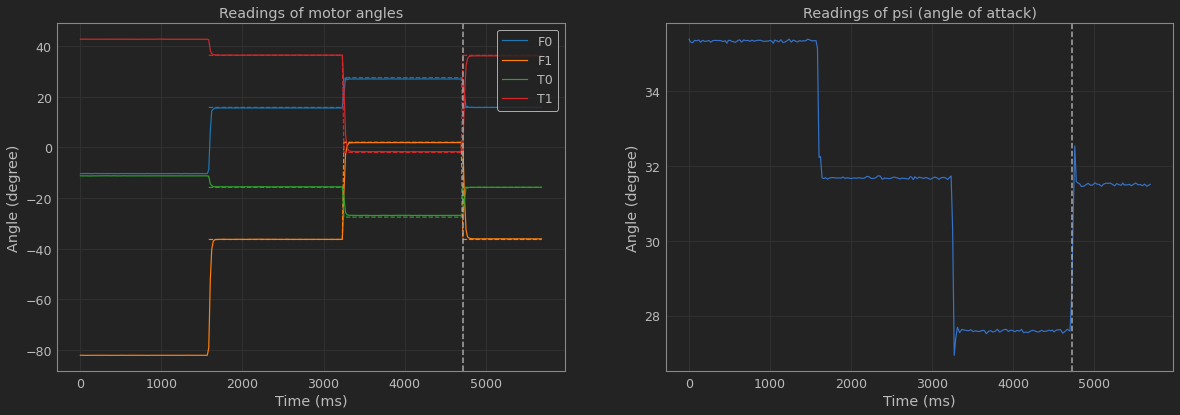

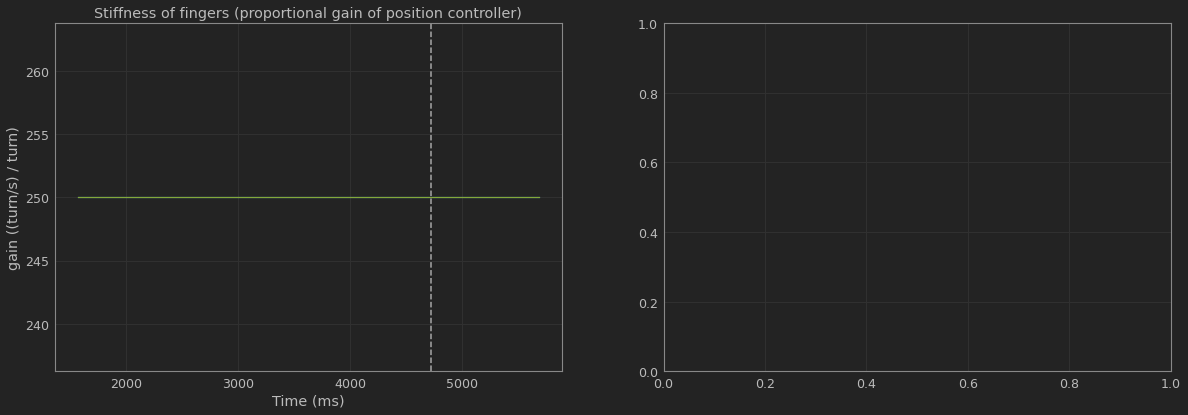

In [5]:
gripper.logged = False
gripper.display_log(30)

#### script testing

In [ ]:
gripper.arm()
gripper.set_stiffness(20)
gripper.set_left_tip((158, 38))
gripper.set_right_tip((158, -38))
# gripper.set_parallel_jaw(-14.5, 0)

In [ ]:
gripper.arm(BW = 0.1)

In [ ]:
gripper.set_left_tip((140, 20))
gripper.set_right_tip((140, -20))

In [ ]:
gripper.set_left_tip((158, 38))
gripper.set_right_tip((158, -38))

#### deceleration control and end pos control

In [ ]:
ur.speedl([0.4,0,0,0,0,0],0.4,10)

In [ ]:
# print(ur.get_tcp_speed(wait=False)[0])
stop_dist = 0.05
end_dist = 0.3
reverse_vel = 0.4
spd_detect = ur.get_tcp_speed(wait=False)[0]
stop_dec = (spd_detect**2)/(2*stop_dist)
ur.speedl([-reverse_vel,0,0,0,0,0],stop_dec,10)
pos_dec = ur.getl()[0]
while ur.get_tcp_speed(wait=False)[0] > 0:
    continue
pos_stop = ur.getl()[0]
print("Reach zero vel!")
t_acc = reverse_vel / stop_dec
s_acc = 0.5 * stop_dec * t_acc**2
t_const = (end_dist-s_acc) / reverse_vel
print(s_acc)
print(t_acc+t_const)
time.sleep(t_acc+t_const)
ur.stopl(5)
pos_end = ur.getl()[0]

In [ ]:
ur.stopl(2)
stop_dist = pos_stop - pos_dec
reverse_dist = pos_end - pos_stop
print(spd_detect)
print(stop_dec)
print(stop_dist)
print(reverse_dist)

In [ ]:
pose = ur.get_pose()
print(pose)
print(ur.getl())

#### scooping test

In [ ]:
scoop.prescoop_initialize((-0.509,0.45,180))
time.sleep(0.5)
a2_init = gripper.right_a2

In [ ]:
# smack and scoop
smack_vel = 0.3 #100
smack_acc = 0.3 #0.3
stop_smack_acc = 3 #7
reverse_vel = 0.3 # 250
reverse_acc = 0.35 #1
stop_acc = 0.5 #0.5
stop_dist = 0.01

# robot accelerate
ur.speedl([0,0,-smack_vel,0,0,0],smack_acc,5)
# robot detect collision, then stop, close gripper, and go up
while 1:
    a2_cur = gripper.right_a2
    #print(a2_cur)
    if a2_cur - a2_init > 0.3:
        print ("Collision detected!")
        z_spd = ur.get_tcp_speed(wait=False)[2]
        stop_dec = (z_spd**2)/(2*stop_dist)
        gripper.set_stiffness(20, 'R')
#         gripper.set_left_tip((158, 38))
#         gripper.set_right_tip((158, -38))
        gripper.set_left_tip((157, 41))
        gripper.set_right_tip((157, -41))
#         ur.stopl(stop_smack_acc)
        gripper.set_stiffness(100)
        ur.speedl([0,0,reverse_vel,0,0,0],stop_smack_acc,5)
        time.sleep(0.2)
        ur.stopl(stop_acc)
        break

In [ ]:
print(z_spd)
print(stop_dec)

In [ ]:
gripper.set_left_tip((157, 41))
gripper.set_right_tip((157, -41))

In [ ]:
ur.stopl()